In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import glob
import cv2

In [2]:
## Pipeline would be created which would do Camera Calibration, Distortion Correction, Color Transformation,
## Prespective Transformation, Lane pixel detection, Lane curvature and Overlay display of detected lanes on 
## original image

In [3]:
def undistort(img, mtx, dist) :
    return cv2.undistort(img, mtx, dist, None, mtx)

## Camera Calibration

In [4]:
def calibrate_camera(images, nx, ny):
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    objpoints = [] 
    imgpoints = []
    image_size = None

    for i, img in enumerate(images):
        img = cv2.imread(img)            
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            image_size = (img.shape[1], img.shape[0])
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None)
    
    return mtx, dist

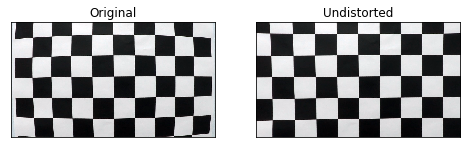

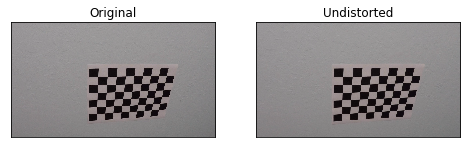

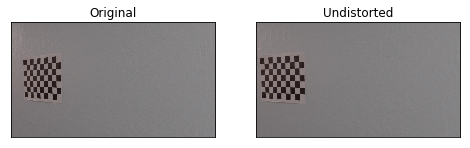

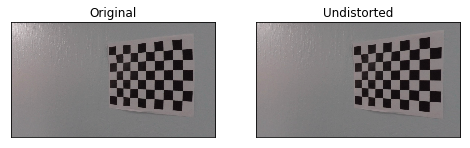

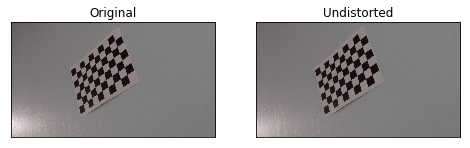

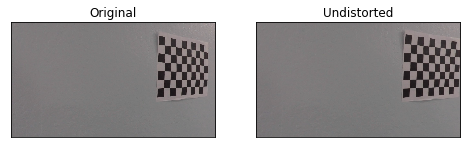

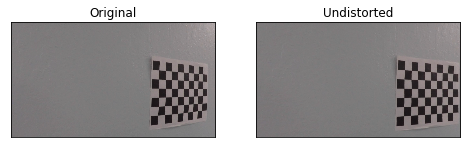

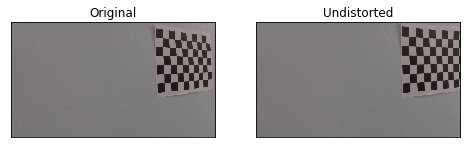

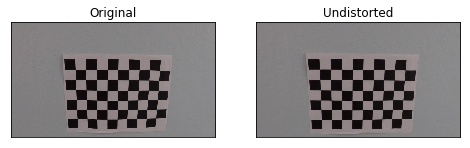

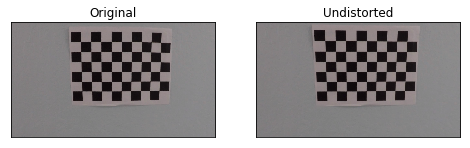

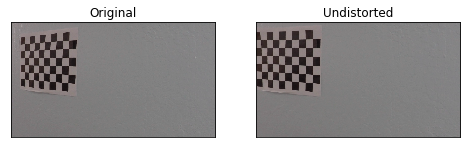

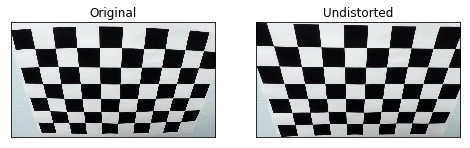

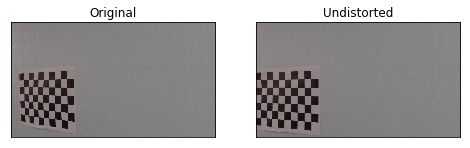

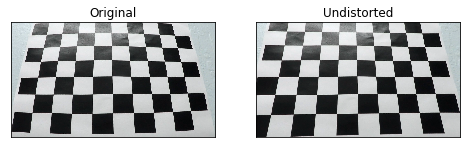

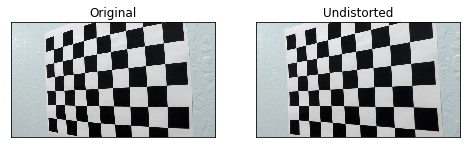

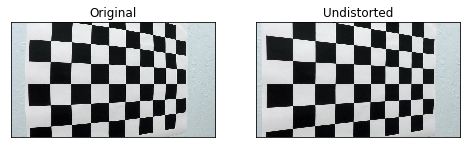

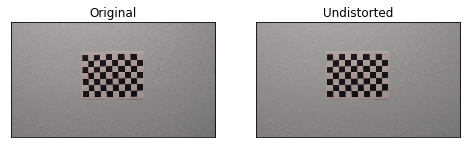

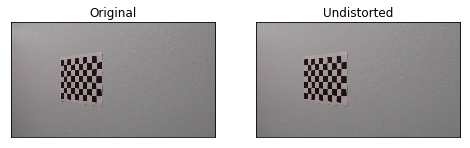

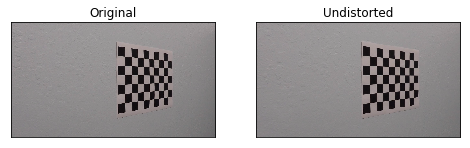

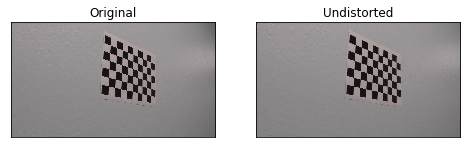

In [5]:
## Test Calibration
images = sorted(glob.glob('./camera_cal/*.jpg'))
nx = 9
ny = 6
mtx, dist = calibrate_camera(images, nx, ny)

for image in images :
    test_image_calibration = np.copy(cv2.imread(image))
    undistorted = undistort(test_image_calibration, mtx, dist)

    figure = plt.figure(figsize=(30, 15))
    plt.subplot(171)
    plt.title("Original")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_image_calibration, cmap='gray')

    plt.subplot(172)
    plt.title("Undistorted")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(undistorted, cmap='gray')

plt.show()

## Distortion Correction

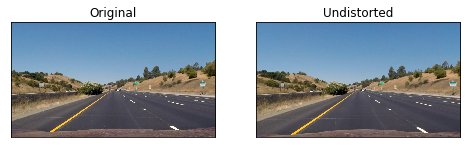

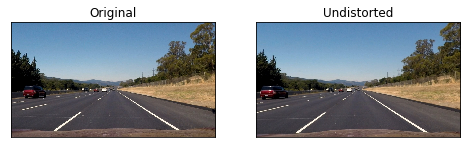

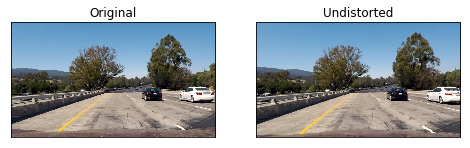

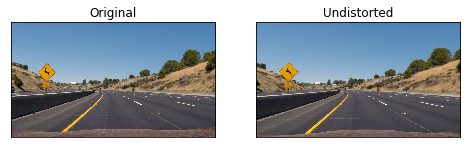

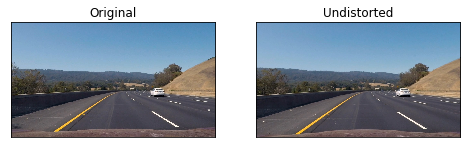

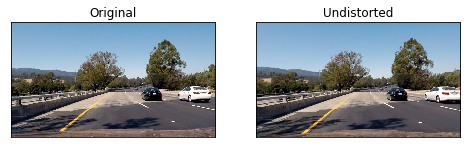

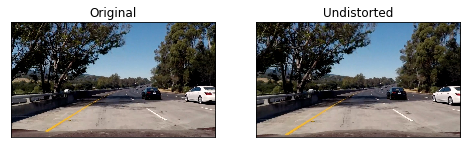

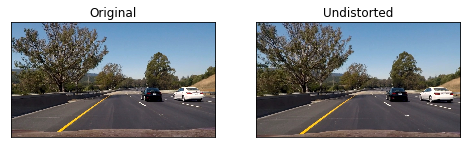

In [6]:
## Testing distortion on test images
test_images = sorted(glob.glob('./test_images/*.jpg'))
for image in test_images :
    test_image_calibration = np.copy(cv2.imread(image)[...,::-1])
    undistorted = undistort(test_image_calibration, mtx, dist)

    figure = plt.figure(figsize=(30, 15))
    plt.subplot(171)
    plt.title("Original")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_image_calibration, cmap='gray')

    plt.subplot(172)
    plt.title("Undistorted")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(undistorted, cmap='gray')

plt.show()

## Binary Image after Color Transformation

In [7]:
def apply_threshold(img, threshold) :
    binary = np.zeros_like(img)
    binary[(img >= threshold[0]) & (img <= threshold[1])] = 1
    return binary

def apply_threshold_scaled(img, threshold) :
    scaled_img = np.uint8(255*img/np.max(img))
    return apply_threshold(scaled_img, threshold)

def narrow_to_roi(color_binary, region) :
    mask = np.zeros_like(color_binary)
    remove_mask_color = 255
    cv2.fillPoly(mask, region, remove_mask_color)
    return cv2.bitwise_and(color_binary, mask)

def transform_binary(undistorted_image, mtx, dist, sobel_kernel=7, threshold=(20, 100)) :
    img = np.copy(undistorted_image)
    img = cv2.GaussianBlur(img, (11, 11), 2)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) 
    abs_sobelx = np.absolute(sobelx) 
    gradx = apply_threshold_scaled(abs_sobelx, (10, 255))
    
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel) 
    abs_sobely = np.absolute(sobely) 
    grady = apply_threshold_scaled(abs_sobely, (60, 255))
    
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    mag = apply_threshold_scaled(magnitude, (60, 255))

    abs_x = np.sqrt(sobelx**2)
    abs_y = np.sqrt(sobely**2)
    
    direction = np.arctan2(abs_y, abs_x)
    di = apply_threshold(direction, (0.5, 1))
    
    combined = np.zeros_like(s_channel)
    combined[((gradx == 1) & (grady == 1)) | ((mag == 1) & (di == 1))] = 1

    s_binary = np.zeros_like(combined)
    s_binary[(s_channel > 170) & (s_channel < 255)] = 1
                            
    color_binary = np.zeros_like(combined)
    color_binary[(s_binary > 0 ) | (combined > 0)] = 1
    
    imshape = undistorted_image.shape
    
    left_bottom = (100, imshape[0])
    right_bottom = (imshape[1] - 20, imshape[0])
    apex1 = (610, 410)
    apex2 = (680, 410)

    inner_left_bottom = (310, imshape[0])
    inner_right_bottom = (1150, imshape[0])
    inner_apex1 = (700, 480)
    inner_apex2 = (650, 480)

    region = np.array([[left_bottom, apex1, apex2, \
                          right_bottom, inner_right_bottom, \
                          inner_apex1, inner_apex2, inner_left_bottom]], dtype=np.int32)
    color_binary = narrow_to_roi(color_binary, region)
    
    return color_binary

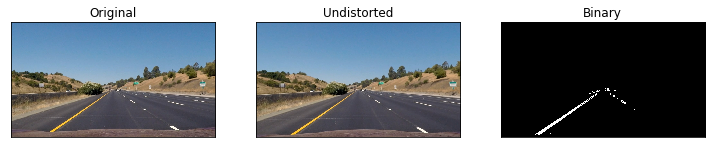

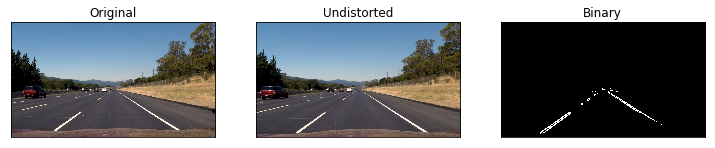

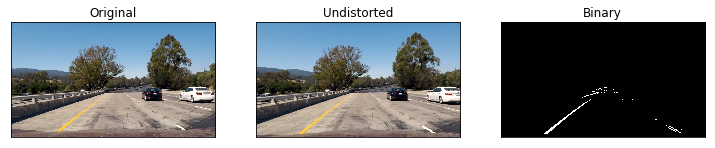

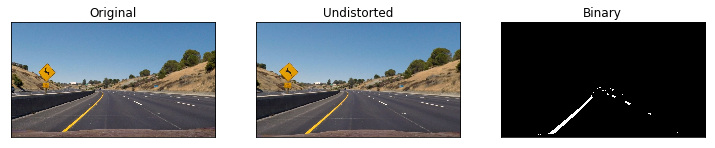

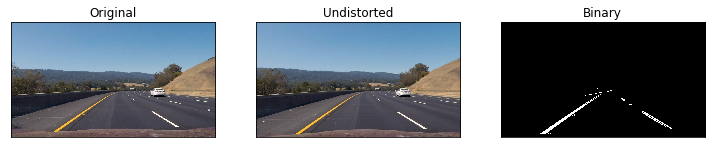

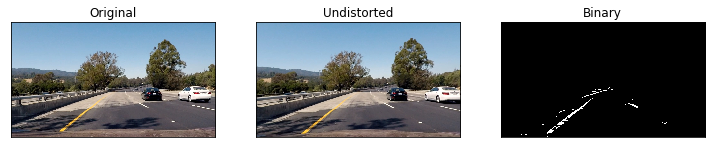

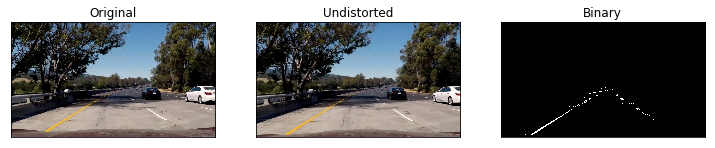

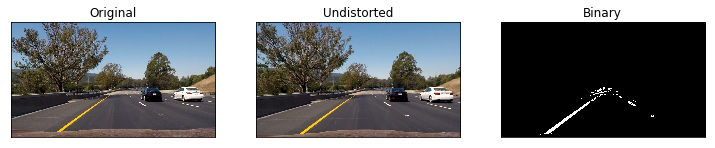

In [8]:
## Test Color Transformation
for image in test_images :
    test_image_calibration = np.copy(cv2.imread(image)[...,::-1])
    undistorted = undistort(test_image_calibration, mtx, dist)
    binary = transform_binary(undistorted, mtx, dist, sobel_kernel=5, threshold=(20, 100))
    
    figure = plt.figure(figsize=(30, 15))
    plt.subplot(171)
    plt.title("Original")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_image_calibration, cmap='gray')

    plt.subplot(172)
    plt.title("Undistorted")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(undistorted, cmap='gray')

    plt.subplot(173)
    plt.title("Binary")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(binary, cmap='gray')

plt.show()

## Perspective Transformation

In [9]:
roi = [[600, 450], [685, 450], [1100, 680], [280, 680]]

def prespective_birdeye(undistorted_image, M) :
    height = undistorted_image.shape[0]
    width = undistorted_image.shape[1]
    return cv2.warpPerspective(undistorted_image, M, (width, height), flags=cv2.INTER_LINEAR)    

def perspective_transformation(binary_image) :
    height = binary_image.shape[0]
    width = binary_image.shape[1]
    src = np.float32(roi)

    offset = 200
    
    dst = np.float32([[offset, 0],
                      [width - offset, 0],
                      [width - offset, height],
                      [offset, height]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(binary_image, M, (width, height), flags=cv2.INTER_LINEAR)
    unwrap_m = cv2.getPerspectiveTransform(dst, src)
    return warped, M, unwrap_m



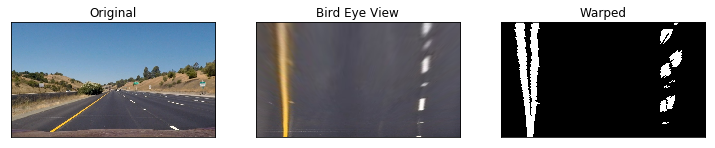

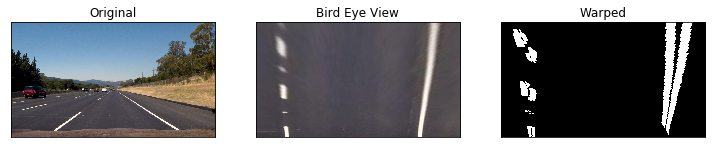

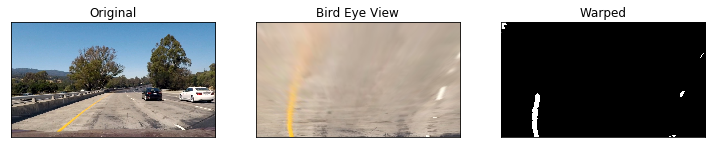

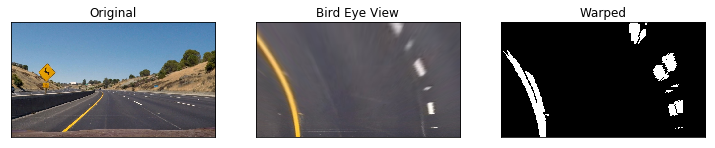

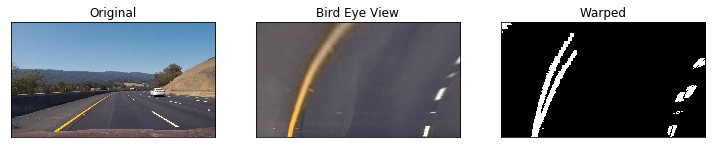

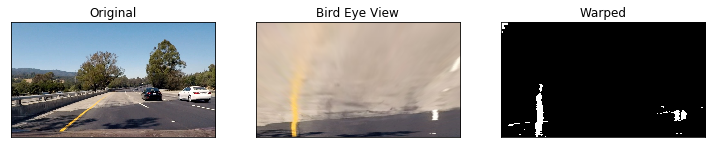

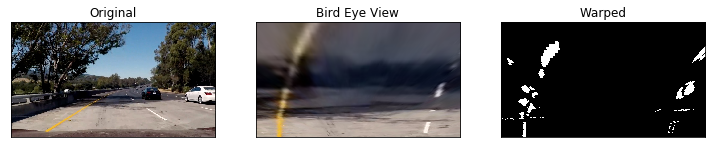

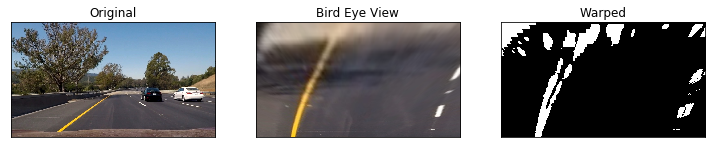

In [10]:
## test perspective transformation
for image in test_images :
    test_image_calibration = np.copy(cv2.imread(image)[...,::-1])
    undistorted = undistort(test_image_calibration, mtx, dist)
    binary = transform_binary(undistorted, mtx, dist, sobel_kernel=5, threshold=(20, 100))
    warped, M, unwrap_m = perspective_transformation(binary)
    birdeye = prespective_birdeye(undistorted, M)
    
    figure = plt.figure(figsize=(30, 15))
    plt.subplot(171)
    plt.title("Original")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_image_calibration)

    plt.subplot(172)
    plt.title("Bird Eye View")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(birdeye)

    plt.subplot(173)
    plt.title("Warped")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(warped, cmap='gray')

plt.show()

## Lane Pixel Detection

In [45]:
def find_lane_pixels(binary_warped, nwindows = 9, margin = 100, minpix=50):
    histogram = np.sum(binary_warped[int(binary_warped.shape[0] / 2):, :], axis=0)
    
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    window_height = np.int(binary_warped.shape[0] / nwindows)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
        
    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current  - margin
        win_xright_high = rightx_current + margin
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0] 
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0] 
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > 0:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > 0:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, histogram

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, histogram = find_lane_pixels(binary_warped)

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return left_fit, right_fit, ploty, left_fitx, right_fitx, histogram

def search_on_sliding_window(binary_warped, left_fit, right_fit, margin = 100):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fit, right_fit, ploty, left_fitx, right_fitx

def calculate_radius(y, fitx):
    y_eval = np.max(y)
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700
    fit_cr = np.polyfit(y * ym_per_pix, fitx * xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

def find_lane(binary_warped, lane_found):
    if lane_found:
        left_fit, right_fit, ploty, left_fitx, right_fitx = search_on_sliding_window(binary_warped, left_fit, right_fit)
        histogram = None
    else:
        left_fit, right_fit, ploty, left_fitx, right_fitx, histogram = fit_polynomial(binary_warped)
        lane_found = True

    left_radius = calculate_radius(ploty, left_fitx)
    right_radius = calculate_radius(ploty, right_fitx)
    
    return left_fit, right_fit, ploty, left_fitx, right_fitx, left_radius, histogram

## Draw Lane

In [46]:
def draw_lane(image, warped_image, ploty, left_fitx, right_fitx, M, radius):
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    left_pts = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_pts = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    
    combined_pts = np.hstack((left_pts, right_pts))
    
    cv2.fillPoly(color_warp, np.int_([combined_pts]), (0,255,0))
    
    new_warp = cv2.warpPerspective(color_warp, M, (image.shape[1], image.shape[0]))
    
    result = cv2.addWeighted(image, 1, new_warp, 0.3, 0)
    
    car_pos = np.argwhere(new_warp[:,:,1])
    
    row, cols = image.shape[:2]
    left_pos = np.plyval()
    right_pos = np.max(car_pos[(car_pos[:,1] < ideal_center) & (car_pos[:,0] > 700)][:,1])
    center = (left_pos + right_pos) / 2
    center = ideal_center
    car_pos = (ideal_center - center)* 3.7/700
    return result, car_pos
    

## Pipeline Definition

In [47]:
def pipeline_histogram(image, plot=False):
    undistorted = undistort(image, mtx, dist)
    binary = transform_binary(undistorted, mtx, dist, sobel_kernel=5, threshold=(20, 100))
    warped, M, unwrap_m = perspective_transformation(binary)
    lane_found = False
    left_fit, right_fit, ploty, left_fitx, right_fitx, left_radius, histogram = find_lane(warped, lane_found)
    result, car_pos = draw_lane(image, warped, ploty, left_fitx, right_fitx, unwrap_m, left_radius)
    text = "Car offset -> " + str(car_pos) + ". Curve -> " + str(left_radius)
    cv2.putText(result, text, (400, 100), cv2.FONT_HERSHEY_PLAIN, 1, (255,0,0),2)
    
    return result, histogram

def pipeline(image):
    result, histogram = pipeline_histogram(image)
    return result

### Testing on images

In [48]:
for image in test_images :
    test_image = np.copy(cv2.imread(image)[...,::-1])
    result, histogram = pipeline_histogram(test_image, plot=True)
    
    figure = plt.figure(figsize=(30, 15))
    plt.subplot(141)
    plt.title("Original")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_image)

    plt.subplot(142)
    plt.title("Final")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(result, cmap='gray')

    plt.subplot(143)
    plt.title("Histogram")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(histogram, cmap='gray')

plt.show()

ValueError: zero-size array to reduction operation minimum which has no identity

### Video Testing

In [20]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

clip = VideoFileClip("project_video.mp4")
project_video = 'project_video-outout.mp4'
white_clip = clip.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_video, audio=False)


[MoviePy] >>>> Building video project_video-outout.mp4
[MoviePy] Writing video project_video-outout.mp4


100%|█████████▉| 1260/1261 [05:41<00:00,  3.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video-outout.mp4 

CPU times: user 3min 38s, sys: 3 s, total: 3min 41s
Wall time: 5min 44s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [26]:
clip1 = VideoFileClip("challenge_video.mp4")
challenge_video = 'challenge_video-outout.mp4'
challenge_video_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time challenge_video_clip.write_videofile(challenge_video, audio=False)

[MoviePy] >>>> Building video challenge_video-outout.mp4
[MoviePy] Writing video challenge_video-outout.mp4


100%|██████████| 485/485 [02:20<00:00,  3.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video-outout.mp4 

CPU times: user 1min 25s, sys: 10.4 s, total: 1min 35s
Wall time: 2min 23s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_video))

In [29]:
clip2 = VideoFileClip("harder_challenge_video.mp4")
harder_challenge_video = 'harder_challenge_video-outout.mp4'
harder_challenge_video_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time harder_challenge_video_clip.write_videofile(harder_challenge_video, audio=False)

[MoviePy] >>>> Building video harder_challenge_video-outout.mp4
[MoviePy] Writing video harder_challenge_video-outout.mp4


100%|██████████| 485/485 [02:21<00:00,  3.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video-outout.mp4 

CPU times: user 1min 25s, sys: 11.6 s, total: 1min 37s
Wall time: 2min 24s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_video))